# Take merged verification files and merge them with the rollout files

In [13]:
import re
import json

model_name = "o4-mini"
dataset_name = "AI2D"
merged_verification_file = f"/mnt/fast10/brandon/mmr_rollout_data/merged_verification_files/{dataset_name}_final_verification_processed_{model_name}.jsonl"
# output_path = f"/mnt/fast10/brandon/mmr_rollout_data/processed_full_verification_files/{dataset_name}_final_mc_and_verification_merged_{model_name}.jsonl"

# Extract verification_solutions from merged file
verification_solutions = []
solution_pattern = re.compile(r'<solution>(.*?)</solution>', re.DOTALL)

with open(merged_verification_file, 'r') as f:
    for line_num, line in enumerate(f, 1):
        item = json.loads(line)
        try:
            text = item["body"]["messages"][0]["content"][0]["text"]
            # Find all matches and get the second one
            matches = solution_pattern.findall(text)
            if len(matches) >= 2:
                solution_text = matches[1].strip()  # Get second occurrence
                if solution_text:  # Only add non-emptyverification_solutions 
                    verification_solutions.append({
                        "custom_id": item.get("custom_id", "ERROR: custom_id not found"),
                        "unique_key": solution_text,
                        "verification_response": item.get("verification_response", "ERROR: verification_response not found"),
                        "o4-mini_isVerified": item.get("o4-mini_isVerified", "ERROR: o4-mini_isVerified not found")
                    })
            elif len(matches) == 1:
                print(f"Warning: Only one <solution> tag found in line {line_num}")
            else:
                print(f"Warning: No <solution> tags found in line {line_num}")
        except (KeyError, IndexError, TypeError) as e:
            print(f"Error accessing text in line {line_num}: {e}")

print(f"Extracted {len(verification_solutions)} valid verification_solutions")

Extracted 24595 valid verification_solutions


In [2]:
# Load flattened file once into memory
full_raw_rollout_data_file = "/mnt/fast10/brandon/mmr_rollout_data/flattened_rollout_files/AI2D_flattened.jsonl"
full_raw_rollout_data_array = []

with open(full_raw_rollout_data_file, 'r') as f:
    for line in f:
        item = json.loads(line)
        full_raw_rollout_data_array.append({
            "response": item.get("response", ""),
            "response_uid": item.get("uid", ""),
            "image_path": item.get("image_path", ""),
        })

print(f"Loaded {len(full_raw_rollout_data_array)} items from flattened file")

Loaded 25557 items from flattened file


In [14]:
# full_raw_rollout_data_array[0].keys()

# print(full_raw_rollout_data_array[0].keys())


# for k,v in full_raw_rollout_data_array[0].items():
#     print(k)
#     print(v)

print(verification_solutions[0].keys())

for k,v in verification_solutions[0].items():
    print(k)
    print(v)

dict_keys(['custom_id', 'unique_key', 'verification_response', 'o4-mini_isVerified'])
custom_id
738acf33-13b2-4336-8720-5ca2cf6503a8
unique_key
[Visual Elements]
<step_1>
The image is a labeled diagram of an animal cell, showing its various organelles.
</step_1>
<step_2>
Key organelles visible and labeled in the image include: Golgi apparatus, Mitochondrion, Nucleus, Cytoplasm, Endoplasmic reticulum, Lysosome, Centriole, Ribosomes, Nucleolus, Genetic material (DNA), Nuclear membrane, and Plasma membrane.
</step_2>
<step_3>
The label “Mitochondrion” is present and points to oblong, orange organelles scattered throughout the cytoplasm.
</step_3>
<step_4>
The label “Golgi apparatus (Golgi body)” points to a stack-like organelle.
</step_4>
<step_5>
The label “Nucleus” points to the central, large, round organelle in the cell.
</step_5>
<step_6>
The label “Cytoplasm” points to the fluid matrix filling much of the cell’s interior.
</step_6>
<step_7>
The question asks which of these organelle

In [15]:
def check_for_collisions(verification_solutions, full_raw_rollout_data_array):
    """
    Check for collisions and missing matches between verification solutions and rollout data.
    
    Returns:
        tuple: (collision_errors, no_matches_array, has_collisions, has_no_matches)
    """
    collision_errors = []
    no_matches_array = []
    
    for sol in verification_solutions:
        unique_key = sol["unique_key"]
        
        # Find all matches
        matches = [item for item in full_raw_rollout_data_array if item["response"].strip() == unique_key]
        
        if len(matches) > 1:
            collision_errors.append({
                "solution_unique_key": unique_key,
                "solution_custom_id": sol["custom_id"],
                "matches": matches
            })
        elif len(matches) == 0:
            no_matches_array.append({
                "solution_unique_key": unique_key,
                "solution_custom_id": sol["custom_id"],
            })

    # Report collision errors
    has_collisions = len(collision_errors) > 0
    has_no_matches = len(no_matches_array) > 0
    
    if has_collisions:
        print(f"\n�� COLLISION ERRORS FOUND: {len(collision_errors)} unique_keys have multiple matches!")
        for error in collision_errors:
            print(f"\nCollision for solution_custom_id: {error['solution_custom_id']}")
            print(f"solution_unique_key: {error['solution_unique_key'][:100]}...")
            print(f"Found {len(error['matches'])} matches:")
            for match in error['matches']:
                print(f"  - response_uid: {match['response_uid']}, response: {match['response'][:50]}...")
    else:
        print(f"\n✅ No collisions found! All {len(verification_solutions)} solutions have at most one match.")

    if has_no_matches:
        print(f"\n🚨 NO MATCHES FOUND: {len(no_matches_array)} unique_keys have no matches!")
        for error in no_matches_array:
            print(f"\nNo match found for solution_custom_id: {error['solution_custom_id']}")
            print(f"solution_unique_key: {error['solution_unique_key'][:100]}...")
    else:
        print(f"\n✅ No no matches found! All {len(verification_solutions)} solutions have at least one match.")
    
    return collision_errors, no_matches_array, has_collisions, has_no_matches

# Test the function
# collision_errors, no_matches_array, has_collisions, has_no_matches = check_for_collisions(
#     verification_solutions, full_raw_rollout_data_array
# )

In [ ]:
def merge_rollout_and_verification_data(verification_solutions, full_raw_rollout_data_array, output_path):
    """
    Merge verification solutions with rollout data when no collisions are detected.
    Uses full_raw_rollout_data_array as the reference point.
    
    Args:
        verification_solutions: List of verification solution dicts
        full_raw_rollout_data_array: List of rollout data dicts
        output_path: Path to save the merged output file
    """
    # First check for collisions
    collision_errors, no_matches_array, has_collisions, has_no_matches = check_for_collisions(
        verification_solutions, full_raw_rollout_data_array
    )
    
    if has_collisions:
        raise ValueError(f"{len(collision_errors)} collision errors found. Cannot proceed with merge.")
    
    # Create lookup dictionary for verification solutions
    verification_lookup = {sol["unique_key"]: sol for sol in verification_solutions}
    
    # Initialize trackers
    rollouts_without_verification = 0
    rollouts_with_verification = 0
    invalid_verification_values = []
    
    # Merge the data - iterate over rollout data as reference
    merged_data = []
    for rollout_item in full_raw_rollout_data_array:
        response_key = rollout_item["response"].strip()
        
        # Check if this rollout has a corresponding verification solution
        if response_key in verification_lookup:
            # Found matching verification solution
            verification_sol = verification_lookup[response_key]
            
            # Validate o4-mini_isVerified value
            is_verified_value = verification_sol.get("o4-mini_isVerified")
            if is_verified_value not in [True, False]:
                invalid_verification_values.append({
                    "o4-mini_verification_custom_id": verification_sol["custom_id"],
                    "o4-mini_verification_response": verification_sol["verification_response"],
                    "o4-mini_isVerified_value": is_verified_value,
                    "type": type(is_verified_value).__name__
                })
            
            merged_item = {
                "o4-mini_verification_custom_id": verification_sol["custom_id"],
                "response_uid": rollout_item["response_uid"],
                "rollout_response": rollout_item["response"],
                "rollout_image_path": rollout_item["image_path"],
                "o4-mini_verification_solution": verification_sol["verification_response"],
                "o4-mini_isVerified": is_verified_value
            }
            rollouts_with_verification += 1
        else:
            # No matching verification solution found
            merged_item = {
                "o4-mini_verification_custom_id": None,
                "response_uid": rollout_item["response_uid"],
                "rollout_response": rollout_item["response"],
                "rollout_image_path": rollout_item["image_path"],
                "o4-mini_verification_solution": None,
                "o4-mini_isVerified": None
            }
            rollouts_without_verification += 1
        
        merged_data.append(merged_item)
    
    # Save to file
    with open(output_path, 'w') as f:
        for item in merged_data:
            f.write(json.dumps(item) + '\n')
    
    print(f"\n✅ Successfully merged {len(merged_data)} items to {output_path}")
    print(f"📊 Summary:")
    print(f"   - Rollouts with verification: {rollouts_with_verification}")
    print(f"   - Rollouts without verification: {rollouts_without_verification}")
    print(f"   - Total rollouts: {len(merged_data)}")
    
    # Report invalid verification values
    if invalid_verification_values:
        print(f"\n⚠️  INVALID VERIFICATION VALUES FOUND: {len(invalid_verification_values)} items. None values acceptable, means the verification returned an error.")
        print("These custom_ids have invalid o4-mini_isVerified values (not True/False):")
        for item in invalid_verification_values:
            print(f"   - verification_custom_id: {item['verification_custom_id']}, o4-mini_isVerified_value: {item['o4-mini_isVerified_value']}, verification_response: {item['verification_response']} (type: {item['type']})")
    else:
        print(f"\n✅ All verification values are valid (True/False)")
    
    return merged_data

# Define output path and run merge
output_path = f"/mnt/fast10/brandon/mmr_rollout_data/processed_full_verification_files/{dataset_name}_final_mc_and_verification_merged_{model_name}.jsonl"

merged_data = merge_rollout_and_verification_data(
    verification_solutions, 
    full_raw_rollout_data_array, 
    output_path
)


✅ No collisions found! All 24595 solutions have at most one match.

✅ No no matches found! All 24595 solutions have at least one match.

✅ Successfully merged 25557 items to /mnt/fast10/brandon/mmr_rollout_data/processed_full_verification_files/AI2D_final_mc_and_verification_merged_o4-mini.jsonl
📊 Summary:
   - Rollouts with verification: 24595
   - Rollouts without verification: 962
   - Total rollouts: 25557

⚠️  INVALID VERIFICATION VALUES FOUND: 2 items
These custom_ids have invalid o4-mini_isVerified values (not True/False):
   - verification_custom_id: 203288af-ef39-41da-bff6-5184ad83b951, o4-mini_isVerified_value: None, verification_response:  (type: NoneType)
   - verification_custom_id: c0cb3f17-b910-4df7-9c55-f2e34f0f4039, o4-mini_isVerified_value: None, verification_response:  (type: NoneType)


In [18]:
# Load and print all values from the merged verification file
import json

# File path
file_path = "/mnt/fast10/brandon/mmr_rollout_data/processed_full_verification_files/AI2D_final_mc_and_verification_merged_o4-mini.jsonl"

print(f"📁 Loading data from: {file_path}")
print("=" * 80)

# Read and print all items
with open(file_path, 'r') as f:
    for line_num, line in enumerate(f, 1):
        item = json.loads(line.strip())
        print(f"\n📄 Item {line_num}:")
        print(json.dumps(item, indent=2))
        print("-" * 40)

print(f"\n✅ Total items printed: {line_num}")


📁 Loading data from: /mnt/fast10/brandon/mmr_rollout_data/processed_full_verification_files/AI2D_final_mc_and_verification_merged_o4-mini.jsonl

📄 Item 1:
{
  "verification_custom_id": "1246cedc-7f5b-4409-9535-2d88841ae65f",
  "response_uid": "b6c24365-7b04-4a00-96fb-4ed28c9fcdfc",
  "rollout_response": "[Visual Elements]\n<step_1>\nIdentify all organisms in the food web: short-eared owl, vole, meadow pippit, emperor moth larvae, red grouse, heather, fox, brown hare, red kite or hen harrier.\n</step_1>\n<step_2>\nNote the arrows indicating feeding relationships: arrows point from food to consumer.\n</step_2>\n<step_3>\nObserve that the fox eats: red grouse, brown hare, and vole (arrows pointing from each of these to fox).\n</step_3>\n<step_4>\nDetermine what eats fox: no arrows point to fox, indicating it is a top predator.\n</step_4>\n<step_5>\nDetermine what else eats red grouse: Arrow from red grouse to fox, and red kite or hen harrier. So red grouse is eaten by fox and red kite/hen

KeyboardInterrupt: 

Total rows loaded: 25557
Columns: ['response_uid', 'rollout_question', 'rollout_response', 'rollout_answer', 'rollout_steps_with_score', 'rollout_image_path', 'o4_mini_verification_custom_id', 'o4_mini_verification_solution', 'o4_mini_isVerified', 'gpt_4.1_mini_verification_custom_id', 'gpt_4.1_mini_verification_solution', 'gpt_4.1_mini_isVerified', 'gpt_4.1_nano_verification_custom_id', 'gpt_4.1_nano_verification_solution', 'gpt_4.1_nano_isVerified']

=== DATASET OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25557 entries, 0 to 25556
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   response_uid                         25557 non-null  object
 1   rollout_question                     25557 non-null  object
 2   rollout_response                     25557 non-null  object
 3   rollout_answer                       25557 non-null  object
 4   rollout_steps_

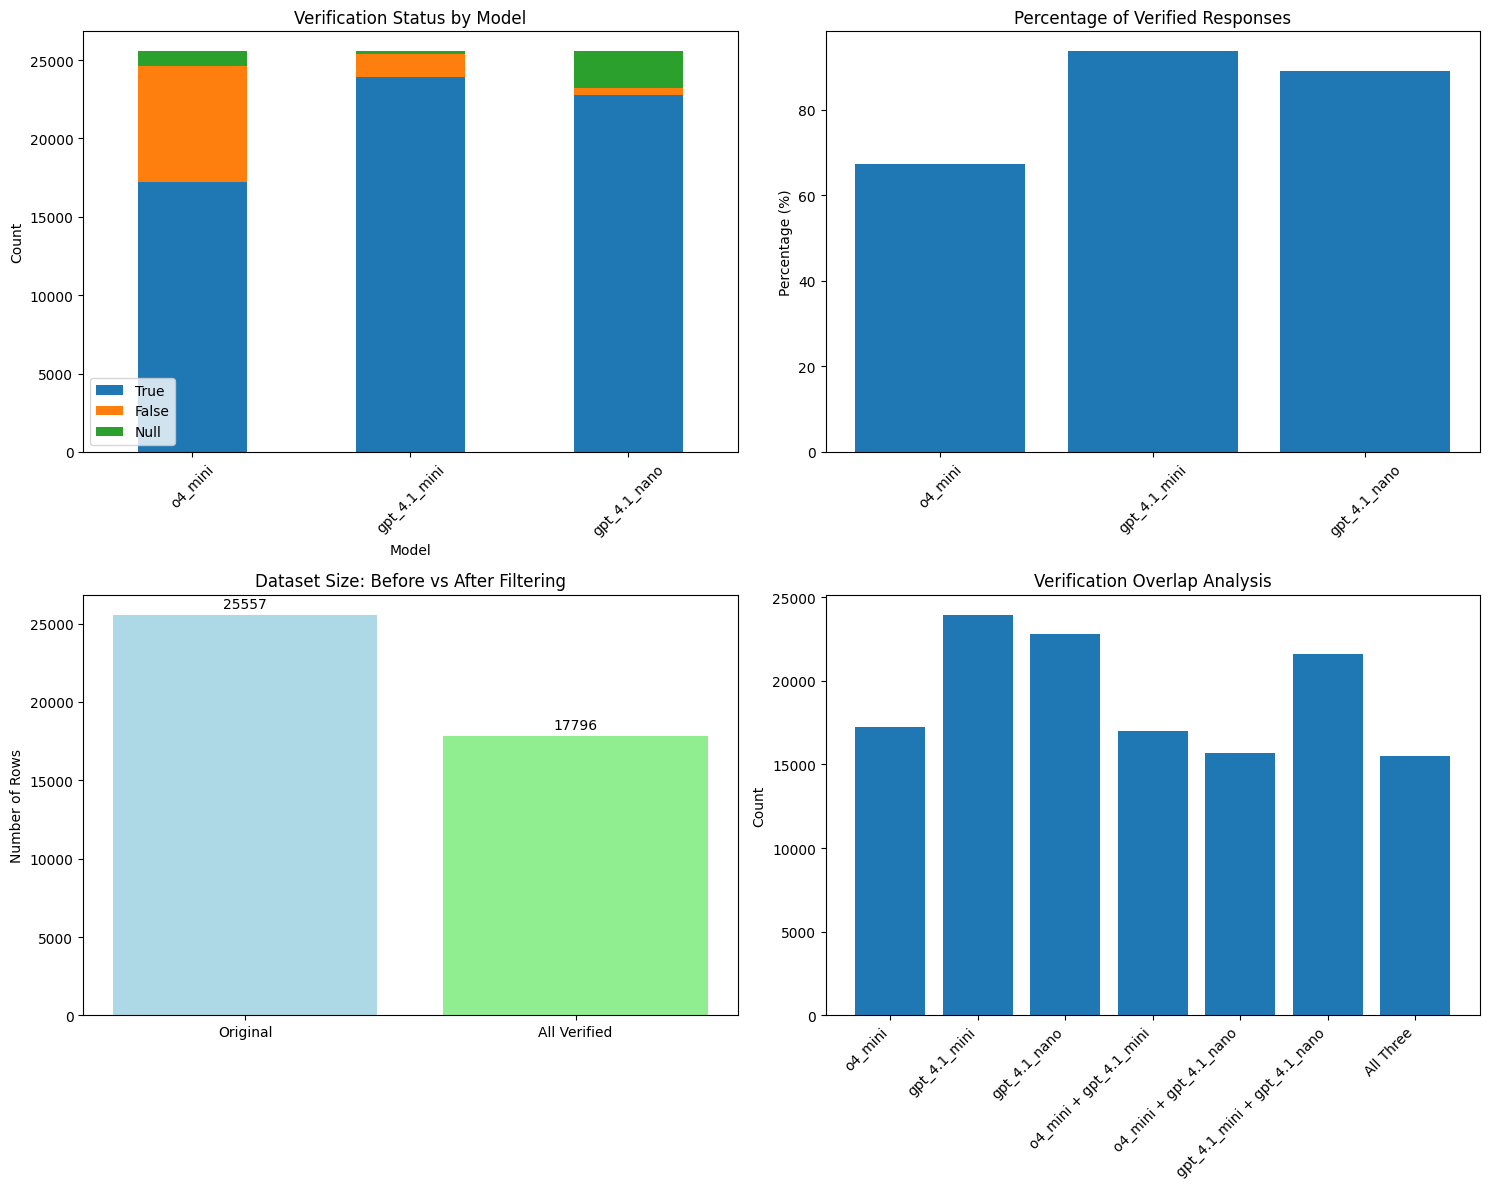


=== SAMPLE OF FILTERED DATA (First 3 rows) ===
                           response_uid rollout_answer o4_mini_isVerified  \
5  b77157ea-dcee-44a6-be87-2e5e8db7ca2b    cladocerans               True   
6  b77157ea-dcee-44a6-be87-2e5e8db7ca2b    cladocerans               True   
7  b77157ea-dcee-44a6-be87-2e5e8db7ca2b    cladocerans               True   

  gpt_4.1_mini_isVerified gpt_4.1_nano_isVerified  
5                    True                    True  
6                    True                    True  
7                    True                    True  

=== FILTERED DATASET STATISTICS ===
Average rollout answer length: 9.22 characters
Unique rollout answers: 2642
Most common rollout answers:
rollout_answer
A           416
C           403
B           388
D           338
decrease    292
Name: count, dtype: int64


In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the JSONL file
file_path = "processed_full_verification_files/AI2D_final_all_models_merged.jsonl"

# Read JSONL file
data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

# Convert to DataFrame
df = pd.DataFrame(data)

print(f"Total rows loaded: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Display basic info
print("\n=== DATASET OVERVIEW ===")
print(df.info())

# Summary statistics for verification columns
verification_cols = ['o4_mini_isVerified', 'gpt_4.1_mini_isVerified', 'gpt_4.1_nano_isVerified']

print("\n=== VERIFICATION STATUS SUMMARY ===")
for col in verification_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts(dropna=False))
        print(f"True percentage: {df[col].sum() / len(df) * 100:.2f}%")

# Create summary plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Verification status for each model
verification_data = []
for col in verification_cols:
    if col in df.columns:
        true_count = df[col].sum()
        false_count = (df[col] == False).sum()
        null_count = df[col].isna().sum()
        verification_data.append({
            'Model': col.replace('_isVerified', ''),
            'True': true_count,
            'False': false_count,
            'Null': null_count
        })

if verification_data:
    verification_df = pd.DataFrame(verification_data)
    verification_df.set_index('Model').plot(kind='bar', stacked=True, ax=axes[0,0])
    axes[0,0].set_title('Verification Status by Model')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Percentage of verified responses
if verification_data:
    percentages = []
    models = []
    for row in verification_data:
        total = row['True'] + row['False'] + row['Null']
        if total > 0:
            percentages.append(row['True'] / total * 100)
            models.append(row['Model'])
    
    axes[0,1].bar(models, percentages)
    axes[0,1].set_title('Percentage of Verified Responses')
    axes[0,1].set_ylabel('Percentage (%)')
    axes[0,1].tick_params(axis='x', rotation=45)

# Filter for all three models verified
print("\n=== FILTERING FOR ALL MODELS VERIFIED ===")
all_verified_mask = df[verification_cols].all(axis=1)
filtered_df = df[all_verified_mask]

print(f"Original rows: {len(df)}")
print(f"Rows after filtering (all verified): {len(filtered_df)}")
print(f"Percentage filtered out: {(len(df) - len(filtered_df)) / len(df) * 100:.2f}%")
print(f"Percentage remaining: {len(filtered_df) / len(df) * 100:.2f}%")

# Plot 3: Before vs After filtering
axes[1,0].bar(['Original', 'All Verified'], [len(df), len(filtered_df)], color=['lightblue', 'lightgreen'])
axes[1,0].set_title('Dataset Size: Before vs After Filtering')
axes[1,0].set_ylabel('Number of Rows')
for i, v in enumerate([len(df), len(filtered_df)]):
    axes[1,0].text(i, v + max(len(df), len(filtered_df)) * 0.01, str(v), ha='center', va='bottom')

# Plot 4: Verification overlap analysis
if all(col in df.columns for col in verification_cols):
    # Create Venn diagram-like analysis
    o4_verified = df['o4_mini_isVerified'] == True
    gpt41_mini_verified = df['gpt_4.1_mini_isVerified'] == True
    gpt41_nano_verified = df['gpt_4.1_nano_isVerified'] == True
    
    overlap_data = {
        'o4_mini': o4_verified.sum(),
        'gpt_4.1_mini': gpt41_mini_verified.sum(),
        'gpt_4.1_nano': gpt41_nano_verified.sum(),
        'o4_mini + gpt_4.1_mini': (o4_verified & gpt41_mini_verified).sum(),
        'o4_mini + gpt_4.1_nano': (o4_verified & gpt41_nano_verified).sum(),
        'gpt_4.1_mini + gpt_4.1_nano': (gpt41_mini_verified & gpt41_nano_verified).sum(),
        'All Three': (o4_verified & gpt41_mini_verified & gpt41_nano_verified).sum()
    }
    
    axes[1,1].bar(range(len(overlap_data)), list(overlap_data.values()))
    axes[1,1].set_title('Verification Overlap Analysis')
    axes[1,1].set_ylabel('Count')
    axes[1,1].set_xticks(range(len(overlap_data)))
    axes[1,1].set_xticklabels(list(overlap_data.keys()), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Display sample of filtered data
print("\n=== SAMPLE OF FILTERED DATA (First 3 rows) ===")
if len(filtered_df) > 0:
    sample_cols = ['response_uid', 'rollout_answer'] + verification_cols
    available_cols = [col for col in sample_cols if col in filtered_df.columns]
    print(filtered_df[available_cols].head(3))
else:
    print("No rows match the filtering criteria!")

# Additional statistics on filtered data
if len(filtered_df) > 0:
    print(f"\n=== FILTERED DATASET STATISTICS ===")
    print(f"Average rollout answer length: {filtered_df['rollout_answer'].str.len().mean():.2f} characters")
    print(f"Unique rollout answers: {filtered_df['rollout_answer'].nunique()}")
    print(f"Most common rollout answers:")
    print(filtered_df['rollout_answer'].value_counts().head(5))

In [1]:
def inspect_prm_training_data(prm_file_path, max_samples=5):
    """
    Inspect PRM training data file structure and content.
    
    Args:
        prm_file_path: Path to the PRM training data file
        max_samples: Maximum number of sample items to analyze
    """
    import json
    import os
    from collections import defaultdict
    
    print(f"🔍 Inspecting PRM training data: {prm_file_path}")
    
    if not os.path.exists(prm_file_path):
        print("❌ File not found!")
        return
    
    # Get file size and line count
    file_size = os.path.getsize(prm_file_path) / (1024 * 1024)  # MB
    with open(prm_file_path, 'r') as f:
        line_count = sum(1 for _ in f)
    
    print(f"📊 File statistics:")
    print(f"   - File size: {file_size:.2f} MB")
    print(f"   - Total lines: {line_count}")
    
    # Load sample data for analysis
    data = []
    unique_ids = set()
    conversation_lengths = []
    image_paths = set()
    
    print(f"📖 Loading and analyzing data...")
    
    with open(prm_file_path, 'r') as f:
        for line_num, line in enumerate(f):
            try:
                item = json.loads(line.strip())
                data.append(item)
                
                # Collect statistics
                unique_ids.add(item.get("id", f"no_id_{line_num}"))
                image_paths.add(item.get("image_path", "no_path"))
                
                # Analyze conversation structure
                conversations = item.get("conversations", [])
                conversation_lengths.append(len(conversations))
                
                # Only analyze first few items in detail
                if len(data) <= max_samples:
                    print(f"\n📋 Sample item {len(data)}:")
                    print(f"   - ID: {item.get('id', 'N/A')}")
                    print(f"   - Image path: {item.get('image_path', 'N/A')}")
                    print(f"   - Conversations: {len(conversations)} turns")
                    
                    # Analyze conversation structure
                    for i, conv in enumerate(conversations[:3]):  # Show first 3 turns
                        role = conv.get("from", "unknown")
                        value = conv.get("value", "")
                        value_preview = value[:100] + "..." if len(value) > 100 else value
                        print(f"     Turn {i+1} ({role}): {value_preview}")
                    
                    if len(conversations) > 3:
                        print(f"     ... and {len(conversations) - 3} more turns")
                
                # Progress update
                if (line_num + 1) % 5000 == 0:
                    print(f"   Processed {line_num + 1} lines...")
                    
            except json.JSONDecodeError as e:
                print(f"❌ JSON decode error at line {line_num + 1}: {e}")
                continue
            except Exception as e:
                print(f"❌ Error processing line {line_num + 1}: {e}")
                continue
    
    # Analyze conversation patterns
    print(f"\n📈 Conversation Analysis:")
    print(f"   - Total unique items: {len(unique_ids)}")
    print(f"   - Total unique images: {len(image_paths)}")
    print(f"   - Average conversation length: {sum(conversation_lengths) / len(conversation_lengths):.1f} turns")
    print(f"   - Min conversation length: {min(conversation_lengths)} turns")
    print(f"   - Max conversation length: {max(conversation_lengths)} turns")
    
    # Analyze conversation length distribution
    length_counts = defaultdict(int)
    for length in conversation_lengths:
        length_counts[length] += 1
    
    print(f"\n📊 Conversation length distribution:")
    for length in sorted(length_counts.keys()):
        count = length_counts[length]
        percentage = (count / len(conversation_lengths)) * 100
        print(f"   - {length} turns: {count} items ({percentage:.1f}%)")
    
    # Analyze conversation roles
    if data:
        print(f"\n🔍 Role analysis (from first {min(max_samples, len(data))} items):")
        role_counts = defaultdict(int)
        for item in data[:max_samples]:
            conversations = item.get("conversations", [])
            for conv in conversations:
                role = conv.get("from", "unknown")
                role_counts[role] += 1
        
        for role, count in sorted(role_counts.items()):
            print(f"   - {role}: {count} turns")
    
    # Check for potential issues
    print(f"\n⚠️  Quality checks:")
    
    # Check for duplicate IDs
    if len(unique_ids) != len(data):
        print(f"   - ⚠️  Duplicate IDs detected: {len(data) - len(unique_ids)} duplicates")
    else:
        print(f"   - ✅ No duplicate IDs found")
    
    # Check for missing image paths
    missing_paths = sum(1 for item in data if not item.get("image_path"))
    if missing_paths > 0:
        print(f"   - ⚠️  Missing image paths: {missing_paths} items")
    else:
        print(f"   - ✅ All items have image paths")
    
    # Check for empty conversations
    empty_conversations = sum(1 for item in data if not item.get("conversations"))
    if empty_conversations > 0:
        print(f"   - ⚠️  Empty conversations: {empty_conversations} items")
    else:
        print(f"   - ✅ All items have conversations")
    
    # Check for very short conversations
    short_conversations = sum(1 for length in conversation_lengths if length < 3)
    if short_conversations > 0:
        print(f"   - ⚠️  Very short conversations (<3 turns): {short_conversations} items")
    
    print(f"\n✅ PRM training data inspection complete!")
    return data

# Run the inspection
prm_file_path = "/mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_all_models_merged_prm_training_data.jsonl"
prm_data = inspect_prm_training_data(prm_file_path, max_samples=3)

🔍 Inspecting PRM training data: /mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_all_models_merged_prm_training_data.jsonl
📊 File statistics:
   - File size: 151.83 MB
   - Total lines: 25557
📖 Loading and analyzing data...

📋 Sample item 1:
   - ID: 000736c4-cd5e-4b9f-9bab-89da5d5044b8
   - Image path: /data/users/brandon/ob1-projects/InternVL/internvl_chat/rollout_generation/preprocessed_prompts/preprocessing_scripts/AI2D/subset_images/3530.png
   - Conversations: 21 turns
     Turn 1 (system): You are an advanced AI assistant, designed to serve as a process supervision model. In this task, I ...
     Turn 2 (human): ### Question:
You are an advanced visual reasoning AI specialized in analyzing images for the Visual...
     Turn 3 (gpt): +
     ... and 18 more turns

📋 Sample item 2:
   - ID: 000736c4-cd5e-4b9f-9bab-89da5d5044b8
   - Image path: /data/users/brandon/ob1-projects/InternVL/internvl_chat/rollout_generation/preprocessed_prompts/preprocessing_scripts